(180.0, 420.0)

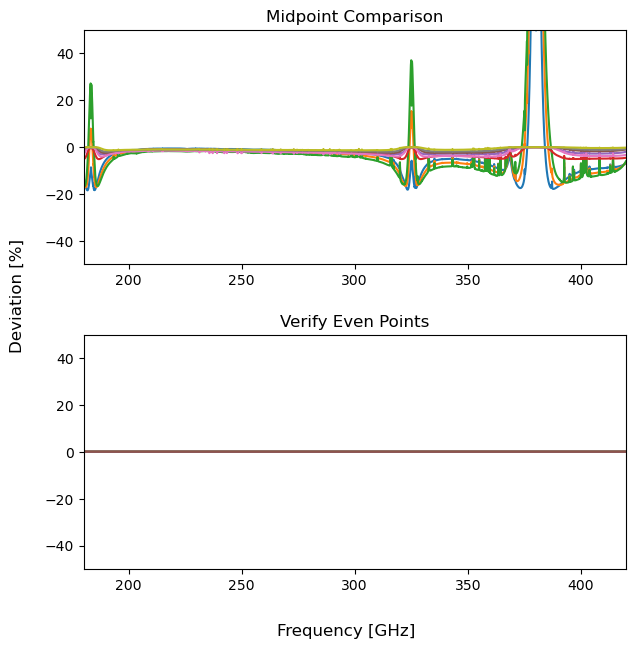

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import tools

Nscale_points = 7
Nscale_map = np.linspace(0, 3, Nscale_points)

ZA_points = 7
airmass_map = np.linspace(1, tools.calc_air_mass(75), ZA_points)
# ZA_map scaling with linear air_mass
ZA_map = tools.calc_zenith(airmass_map)

freq_points = 240001
Tb_scalar_field = np.zeros((Nscale_points, ZA_points, freq_points))
Nscale_jacobian = np.zeros((Nscale_points, ZA_points, freq_points))
airmass_jacobian = np.zeros((Nscale_points, ZA_points, freq_points))

# Load interpolation & jacobian data
for idx, Nscale in enumerate(Nscale_map):
    for jdx, airmass in enumerate(airmass_map):

        filename = f'MaunaKea_Tb_Spectrum_{airmass:.1f}_{Nscale:.1f}'
        data = np.load(f'./data/{filename}.out')

        freq_map = data[:,0]
        
        # Second column is Tb in K
        Tb_scalar_field[idx,jdx] = data[:,2]

        # Jacobian
        conversation_factor = 2109.86 * 10**-3
        Nscale_jacobian[idx,jdx] = (data[:,4] / conversation_factor)

        ZA = tools.calc_zenith(airmass)     # Deg
        airmass_jacobian[idx,jdx] = (data[:,3]) * ( np.sin(np.radians(ZA)) / ((np.cos(np.radians(ZA)))**2) ) * (np.pi / 180)

data_dict = tools.dictionarify(Nscale_points=Nscale_points, Nscale_map=Nscale_map, Nscale_jacobian=Nscale_jacobian,
             airmass_points=ZA_points, airmass_map=airmass_map, airmass_jacobian=airmass_jacobian,
             freq_points=freq_points, freq_map=freq_map, Tb_scalar_field=Tb_scalar_field)

eval_grid = np.zeros_like(data_dict['Tb_scalar_field'])
for idx, Nscale in enumerate(data_dict['Nscale']['map']):
    for jdx, airmass in enumerate(data_dict['airmass']['map']):
        eval_grid[idx,jdx] = tools.DD_CubicHermiteSpline(
            eval_airmass=airmass, eval_nscale=Nscale, data_dict=data_dict, reverse=False
        )
comparison_grid = ((eval_grid - Tb_scalar_field) / Tb_scalar_field) * 100

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(7, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.3)

freq_channels = np.linspace(180, 420, freq_points)
for idx in range(1, Nscale_points, 2):
    for jdx in range(1, ZA_points, 2):
        ax1.plot(freq_channels, comparison_grid[idx,jdx])

fig.supylabel("Deviation [%]")
fig.supxlabel("Frequency [GHz]")

ax1.set_title("Midpoint Comparison")
ax1.set_ylim(-50, 50)
ax1.set_xlim(180, 420)

freq_channels = np.linspace(180, 420, freq_points)
for idx in range(0, Nscale_points, 2):
    for jdx in range(0, ZA_points, 2):
        ax2.plot(freq_channels, comparison_grid[idx,jdx])

ax2.set_title("Verify Even Points")
ax2.set_xlim(180, 420)

Text(0.5, 1.0, 'Compare Interpolation Order of Operation')

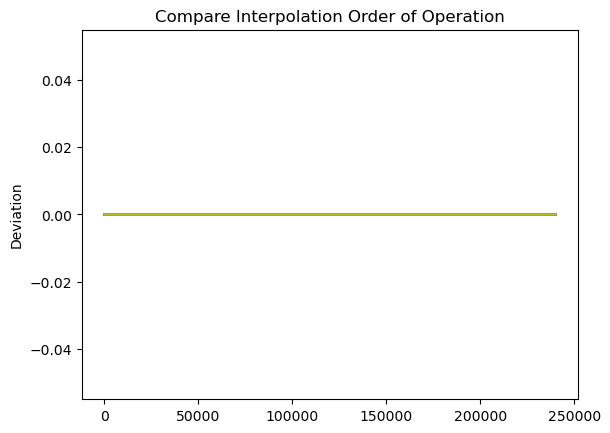

In [10]:
eval_grid_true = np.zeros_like(Tb_scalar_field)
for idx, Nscale in enumerate(Nscale_map):
    for jdx, airmass in enumerate(airmass_map):
        eval_grid[idx,jdx] = tools.DD_CubicHermiteSpline(
            eval_airmass=airmass, eval_nscale=Nscale, data_dict=data_dict, reverse=True
        )

comparison_grid_true = ((eval_grid_true - Tb_scalar_field) / Tb_scalar_field) * 100

eval_grid_false = np.zeros_like(Tb_scalar_field)
for idx, Nscale in enumerate(Nscale_map):
    for jdx, airmass in enumerate(airmass_map):
        eval_grid[idx,jdx] = tools.DD_CubicHermiteSpline(
            eval_airmass=airmass, eval_nscale=Nscale, data_dict=data_dict, reverse=False
        )

comparison_grid_false = ((eval_grid_true - Tb_scalar_field) / Tb_scalar_field) * 100

comparison_grid_true_false = comparison_grid_false - comparison_grid_false

for idx in range(0, Nscale_points):
    for jdx in range(0, ZA_points):
        plt.plot(comparison_grid_true_false[idx,jdx])

plt.ylabel("Deviation")
plt.title("Compare Interpolation Order of Operation")